In [2]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import einops 
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader


from torchvision import transforms
from torchvision import datasets


#* set reporoducibility 
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


In [3]:
## Parameters

Batch_size = 8
n_epochs = 20
lr = 1e-3


In [4]:
def show_images(images, title=""):
    # *detaching tensors to save ram
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # * containing box
    fig = plt.figure(figsize=(4, 4))
    rows = int(len(images) ** 0.5)
    cols = round(len(images) / rows)

    # * adjusting subplots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)
            
            if idx < len(images):
                if images[idx].shape[0] == 1:
                    plt.imshow(images[idx][0], cmap="gray")
                else:
                    plt.imshow(images[idx].transpose(1, 2, 0))
            plt.axis("off")
            idx += 1
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    plt.show()
    
#* show the first batch of images
def show_first_batch(loader):
    for batch in loader :
        show_images(batch[0], title="First batch of images")
        break

## load transforms

In [5]:
transormations = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: (x * 2) - 1)]
)

conversions = transforms.Compose(
    [transforms.Lambda(lambda x: (x + 1) / 2 * 255), transforms.ToPILImage()]
)

data = datasets.FashionMNIST(root="data", download=True, transform=transormations)
loader = DataLoader(data, batch_size=Batch_size, shuffle=True)


Sample, train_data = torch.utils.data.random_split(data, [2048, len(data) - 2048])
sample_loader = DataLoader(Sample, batch_size=Batch_size, shuffle=True)

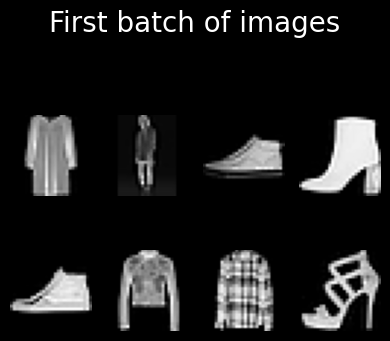

In [6]:
show_first_batch(loader)

In [7]:
## DDPM class - forward pass


class MarkovDDPM(nn.Module):
    def __init__(self, network, n_stepss, start, end, device, image_ch=((1, 28, 28))):
        super().__init__()
        
        self.network = network
        self.n_stepss = n_stepss
        self.start = start
        self.end = end
        self.device = device
        self.image_ch = image_ch
        
        #* define process 
        self.betas = torch.linspace(start, end, n_stepss).to(device)
        self.alphas = 1 - self.betas
        #self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i+1]) for i in range(len(self.alphas))]).to(device)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)
        
    def forward(self, x0, t, noise=None):
        n_batch, n_ch, n_row, n_col = x0.shape
        print(t)
        a_bar = self.alpha_bars[t]
        print(a_bar)
        
        #* generate noise if not given
        if noise is None:
            noise = torch.randn(x0.shape).to(self.device)

        # noisy = img*sqrt(a_bar) + sqrt(1-a_bar)*noise
        noisy = torch.sqrt(a_bar).reshape(-1, 1, 1, 1) * x0 + torch.sqrt(1 - a_bar).reshape(-1, 1, 1, 1) * noise
        
        return noisy
    
    #* for the U-net
    def backward(self, x, t):
        return self.network(x, t)

9
tensor(0.3223)


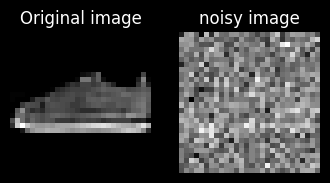

In [8]:
x, _ = next(iter(sample_loader))
ddpm = MarkovDDPM(
    network=None,
    n_stepss=10,
    start=0.01,
    end=0.2,
    device="cpu",
    image_ch=((1, 28, 28)),
)

sample = ddpm(x, 9)

fig = plt.figure(figsize=(4, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(x[0][0], cmap="gray")
plt.title("Original image")
plt.axis("off")

fig.add_subplot(1, 2, 2)
plt.imshow(sample[0][0], cmap="gray")
plt.title("noisy image")
plt.axis("off")
plt.show()



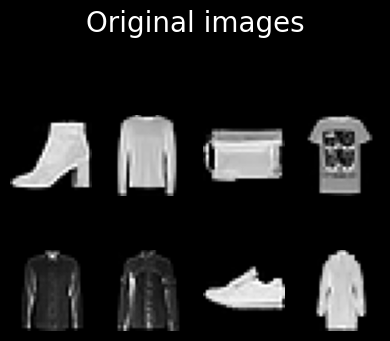

1
tensor(0.9592)


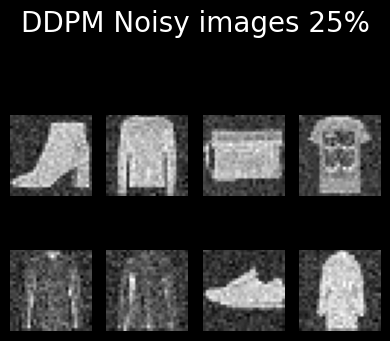

4
tensor(0.7629)


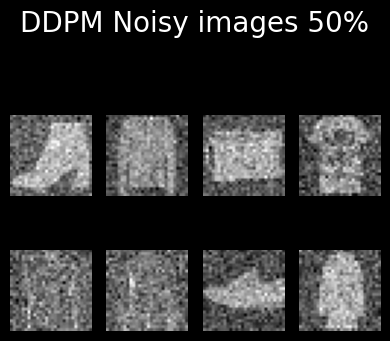

6
tensor(0.5825)


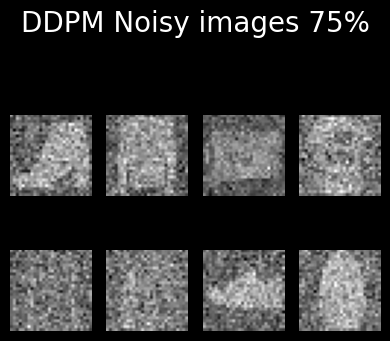

9
tensor(0.3223)


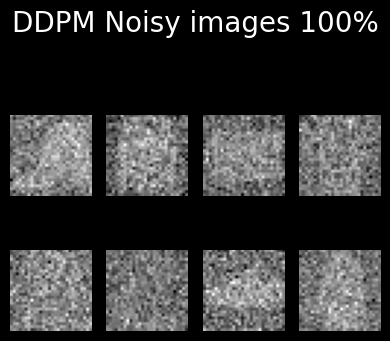

In [9]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                #images= ddpm(imgs.to(device),[int(percent * ddpm.n_stepss) - 1 for _ in range(len(imgs))]), 
                images= ddpm(imgs.to(device),int(percent * ddpm.n_stepss) - 1), 
                title= f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

show_forward(ddpm, loader, "cpu")

## Forward pass

## paramerts

- Eta = Noise
- eta_thera = backprobagated noise

$$
x_t = \frac{1}{\sqrt{\bar{\alpha_t}}} * (x - \frac{1- \alpha_t}{1 - \sqrt{1-\bar{\alpha_t}}} * \eta_t)
$$

$$
x_t = x_t + \sigma_t * random_noise
$$


In [10]:
def generate_new_images(
    ddpm,
    n_sample=16,
    device=None,
    frames_oer_gif=100,
    gif_name="ddpm_samping.gif",
    n_c=3,
    img_h=28,
    img_w=28,
):
    #* line space of the steps 
    frames_idx = np.linspace(0, ddpm.n_stepss, frames_oer_gif).astype(np.uint8)
    frames = []
    
    with torch.no_grad():
        if device is  None:
            device = ddpm.device
            
        #* generate noise
        x = torch.randn(n_sample, n_c, img_h, img_w).to(device) #* input shape
        
        #* generate images
        for idx, t in enumerate(list(range(ddpm.n_stepss))[::-1]): #* reverse order
            #* estimating noise to be removed 
            
            time_tensor = (torch.ones(n_sample, 1) * t).to(device).long() #shape (batch_size, 1)
            
            #* back propogated noise
            eta_theta = ddpm.backward(x, time_tensor) #* shape (batch_size, n_c, img_h, img_w)
            
            alpha_t = ddpm.alphas[t]
            alpha_bar_t = ddpm.alpha_bars[t]
            
            x = (1/ torch.sqrt(alpha_t)) * (x - (1 -  alpha_t)/ (torch.sqrt(1-alpha_bar_t)) * eta_theta) 
            
            if t >0 :
                z = torch.randn(n_sample, n_c, img_h, img_w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = torch.sqrt(beta_t)
                
                #* applying Langevin Dynamics noise
                x = x + sigma_t * z 
                
                
            ## Creating the gif
            #* adding frames to the gif
            if idx in frames_idx or t == 0:
                normalized = x.clone()
                
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])
                    
                #* resahimg to a square image
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c" , b1 = int(n_sample ** 0.5), b2 = int(n_sample ** 0.5))
                frames.append(frame.cpu().numpy().astype(np.uint8))
                
    #* saving the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_oer_gif // 3):
                    writer.append_data(frame)
            
    return x




## Building the U-Net

In [11]:
class Block(nn.Module):
    def __init__(
        self,
        shape,
        in_c,
        out_c,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normaliza=True,
    ):
        super().__init__()

        self.layer_norm = nn.LayerNorm(shape)  # * normalizing over the channels
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        # * sigmoid linear unit SiLU : x * sigmoid(x)
        self.activation = nn.SiLU() if activation is None else activation
        self.norm = normaliza

    def forward(self, x):
        # * normalizing over the channels if needed
        out = self.layer_norm(x) if self.norm else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

## Positonal Embedding

In [12]:
import torch 
import math

class SinsuoidalPostionalEmbedding(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, sequence, device = None):
        """
        equation: 
            - n  =log_2(10000) / (d - 1)
            - d = dim // 2
            - embedding = exp(d * -n) for d = 0, 1, 2, ..., d-1
            - embedding_space = sequence[:, None] * embedding[None, :]
            - sine_embedding = sin(embedding_space)
            - cosine_embedding = cos(embedding_space)
            - embedding = concat(sine_embedding, cosine_embedding)
        """

        d = self.dim // 2
        n = math.log(10000) / (d - 1 + 1e-8) #* n
        
        #* d^(-n) where d = 0, 1, 2, ..., d-1
        #* tensor of shape (d,)
        embedding = torch.exp(torch.arange(d, device=device) * -n) 
        embedding = sequence[:, None] * embedding[None, :] #* (seq_len, d)
        
        #* sin(embedding) and cos(embedding), then concat them
        embedding = torch.cat((embedding.sin(), embedding.cos()), dim=-1) #* (seq_len, 2d)
        
        return embedding

    
    
sinusoidal_embedding = SinsuoidalPostionalEmbedding(4)
sequence = torch.arange(4)
sinusoidal_embedding(sequence)
        

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  1.0000e-04,  5.4030e-01,  1.0000e+00],
        [ 9.0930e-01,  2.0000e-04, -4.1615e-01,  1.0000e+00],
        [ 1.4112e-01,  3.0000e-04, -9.8999e-01,  1.0000e+00]])

## UNET

In [13]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [56]:
from torch import nn
import torch.nn.functional as F


import torchviz


class UNET(nn.Module):
    def __init__(self, n_steps=100, time_emb_dim=100, device="cpu"):
        super().__init__()

        # * sinusoidal positional embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = SinsuoidalPostionalEmbedding(time_emb_dim)(torch.arange(n_steps, device=device)).to(device)
        self.time_embed.requires_grad_(False)

        # * Brain_puler Embedding
        # self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        # self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        # self.time_embed.requires_grad_(False)

        ################### First Half of the U-net ###################

        ##*part 1
        self.te1 = self._make_te(time_emb_dim, 1)
        # * te1 is the time embedding for the first half of the U-net
        self.block1 = nn.Sequential(
            # *(batch_size, 1, 28, 28) to (batch_size, 10, 28, 28)
            Block(shape=(1, 28, 28), in_c=1, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10),
        )
        self.down1 = nn.Conv2d(10, 10, 2, 2)
        # * (batch_size, 10, 28, 28) to (batch_size, 10, 14, 14)
        # * try MaxPool2d instead of Conv2d

        ##*part 2
        self.te2 = self._make_te(time_emb_dim, 10)
        # * te2 is the time embedding for the second half of the U-net
        self.block2 = nn.Sequential(
            # * (batch_size, 10, 14, 14) to (batch_size, 20, 14, 14)
            Block(shape=(10, 14, 14), in_c=10, out_c=20),
            Block(shape=(20, 14, 14), in_c=20, out_c=20),
            Block(shape=(20, 14, 14), in_c=20, out_c=20),
        )
        self.down2 = nn.Conv2d(20, 20, 2, 2)
        # * (batch_size, 20, 14, 14) to (batch_size, 20, 7, 7)

        ##* part 3
        self.te3 = self._make_te(time_emb_dim, 20)
        # * te3 is the time embedding for the third half of the U-net
        self.block3 = nn.Sequential(
            # * (batch_size, 20, 7, 7) to (batch_size, 40, 7, 7)
            Block(shape=(20, 7, 7), in_c=20, out_c=40),
            Block(shape=(40, 7, 7), in_c=40, out_c=40),
            Block(shape=(40, 7, 7), in_c=40, out_c=40),
        )

        # * down3 is the last down sampling layer
        # * (batch_size, 40, 7, 7) to (batch_size, 40, 3, 3)
        #! maxpooling won't work here, may be try
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 2),
            nn.SiLU(),
            nn.Conv2d(40, 40, 1, 1),
        )

        ## Bottleneck
        # upsample the image from (batch_size, 40, 3, 3) to (batch_size, 20, 3, 3)

        # * time embedding for the bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.bottleneck = nn.Sequential(
            # * (batch_size, 40, 3, 3) to (batch_size, 40, 3, 3)
            Block(shape=(40, 3, 3), in_c=40, out_c=20),
            Block(shape=(20, 3, 3), in_c=20, out_c=20),
            Block(shape=(20, 3, 3), in_c=20, out_c=40),
        )

        ################### Second Half of the U-net ###################

        # * first upsample block
        self.up1 = nn.Sequential(
            # * (batch_size, 20, 3, 3) to (batch_size, 20, 7, 7)
            nn.ConvTranspose2d(
                40, 40, 4, 2, 1
            ),  # kernel_size =4 , stride = 2, padding = 1
            nn.SiLU(),
            nn.ConvTranspose2d(
                40, 40, 2, 1
            ),  # kernel_size = 2, stride = 1, padding = 0
        )

        # * 4th time embedding layer
        self.te4 = self._make_te(time_emb_dim, 80)

        # * feature extraction block, inserted after the first upsample block
        # * to extract features from the skip connection
        # * reduce the number of channels from 80 to 20
        self.block4 = nn.Sequential(
            # * (batch_size, 80, 7, 7) to (batch_size, 20, 7, 7)
            Block(shape=(80, 7, 7), in_c=80, out_c=40),
            Block(shape=(40, 7, 7), in_c=40, out_c=20),
            Block(shape=(20, 7, 7), in_c=20, out_c=20),
        )
        # * second upsample block
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        # * (batch_size, 20, 7, 7) to (batch_size, 20, 14, 14)

        # * 5th time embedding layer
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            # * (batch_size, 40, 14, 14) to (batch_size, 10, 14, 14)
            Block(shape=(40, 14, 14), in_c=40, out_c=20),
            Block(shape=(20, 14, 14), in_c=20, out_c=10),
            Block(shape=(10, 14, 14), in_c=10, out_c=10),
        )

        # * third upsample block
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        # * output time embedding layer
        self.te_out = self._make_te(time_emb_dim, 20)

        # * output block
        self.out_block = nn.Sequential(
            # * (batch_size, 10, 28, 28) to (batch_size, 10, 28, 28)
            Block(shape=(20, 28, 28), in_c=20, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10),
            Block(shape=(10, 28, 28), in_c=10, out_c=10, normaliza=False),
        )

        # * output convolution layer
        # * (batch_size, 10, 28, 28) to (batch_size, 1, 28, 28)
        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out),
        )

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)  # * batch size

        # * x + te1(t) where te1 is the time embedding for the first half of the U-net
        # * apply dynamic additive noise to the input with the time embedding

        # * (batch_size, 1, 28, 28) to (batch_size, 10, 28, 28)
        # time_embedded = self.te1(t).reshape(n, -1, 1, 1)
        out1 = self.block1(x + self.te1(t).reshape(n, -1, 1, 1))

        # * (batch_size, 10, 28, 28) to (batch_size, 20, 14, 14)
        out2 = self.block2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))

        # * (batch_size, 20, 14, 14) to (batch_size, 40, 7, 7)
        out3 = self.block3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))

        # * (batch_size, 40, 7, 7) to (batch_size, 40, 3, 3)
        bottelneck = self.bottleneck(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )

        # * (batch_size, 40, 3, 3) to (batch_size, 20, 3, 3)
        skip1 = torch.cat(
            (out3, self.up1(bottelneck)), dim=1
        )  # * [batch_size, 80, 7, 7])

        # * [batch_size, 80, 7, 7]) to (batch_size, 20, 7, 7)
        out4 = self.block4(
            skip1 + self.te4(t).reshape(n, -1, 1, 1)
        )  # * (batch_size, 20, 7, 7)

        # * (batch_size, 20, 7, 7) to (batch_size, 20, 14, 14)
        skip2 = torch.cat((out2, self.up2(out4)), dim=1)  # * (batch_size, 40, 14, 14)

        # * (batch_size, 40, 14, 14) to (batch_size, 10, 14, 14)
        out5 = self.b5(skip2 + self.te5(t).reshape(n, -1, 1, 1))

        # *model output
        skip3 = torch.cat((out1, self.up3(out5)), dim=1)  # * (batch_size, 20, 28, 28)
        out6 = self.out_block(skip3 + self.te_out(t).reshape(n, -1, 1, 1)) #* (batch_size, 10, 28, 28)

        diffused_batch = self.conv_out(out6) #* (batch_size, 1, 28, 28)

        return diffused_batch


model = UNET()

x = torch.randn(Batch_size, 1, 28, 28)  # * [batch_size, 1, 28, 28]
t = torch.randint(0, 100, (Batch_size, 1))  # * [batch_size, 1]
out_1 = model(x, t)

out_1.shape

torch.Size([8, 1, 28, 28])

In [59]:
#import torchviz
#torchviz.make_dot(out_1.mean(), params=dict(model.named_parameters()))
# torch.onnx.export(
#     model,
#     (x, t),
#     "unet.onnx",
#     input_names=["input"],
#     output_names=["output"],
#     opset_version=15,
#     do_constant_folding=True,
#     verbose=False,
# )

# import netron
# netron.start('unet.onnx')


In [27]:
def _output_shape_cal(input_shape, kernel_size, stride, padding):
    """
    calculate the output shape of a convolution layer
    """
    return (input_shape - kernel_size + 2 * padding) / stride + 1


_output_shape_cal(64, 4, 2, 0)

31.0

In [29]:
_output_shape_cal(3,1,1,0)

3.0

In [15]:
def _smake_te(dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.ReLU(),
        nn.Linear(dim_out, dim_out),
    )
    
    